## Speed Dating

The data comes from https://www.kaggle.com/datasets/ulrikthygepedersen/speed-dating, which in turn is derived from http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/. A series of 21 speed-dating events were held in 2002-2004, and data was collected about participants before and during the event. The dataset includes information about participants' age, gender, race, attributes, priorities, interests, and reactions to one another.

This is a small project undertaken for the purpose of practice. Comments and critique are very welcome!

First I will tidy up the data a bit, then I will try to answer a number of questions using this data.

There appears to be a lot of missing data, but I will deal with a lot of that separately for each question, since in many cases the missing data wouldn't be important in addressing a particular question.

In [85]:
import pandas as pd

df = pd.read_csv('./speeddating.csv')

# Remove wave 12, because participants were only allowed to vote yes for up to 50% of their dates; that data might be 
# very different from the other waves
df = df.loc[(df["wave"] != 12), :]

# Transform the preferences data for waves 6-9, because they used a 1-10 scale instead of a percentages scale
df["pref_o_total"] = df["pref_o_attractive"] + df["pref_o_sincere"] + df["pref_o_intelligence"] + df["pref_o_funny"] + df["pref_o_ambitious"] + df["pref_o_shared_interests"]
df["important_total"] = df["attractive_important"] + df["sincere_important"] + df["intellicence_important"] + df["funny_important"] + df["ambtition_important"] + df["shared_interests_important"]
for feat in ["pref_o_attractive", "pref_o_sincere", "pref_o_intelligence", "pref_o_funny", "pref_o_ambitious", "pref_o_shared_interests"]:
    df[feat] = 100 * df[feat] / df["pref_o_total"]
for feat in ["attractive_important", "sincere_important", "intellicence_important", "funny_important", "ambtition_important", "shared_interests_important"]:
    df[feat] = 100 * df[feat] / df["important_total"]
df = df.drop(["pref_o_total", "important_total"], axis=1)

## Predicting matches

I will actually try predicting not the 'match' between two participants, but instead whether the subject of a row will select 'yes' for their partners, regardless of whether their partners also say 'yes'. This is because I want to investigate questions about what influences how much a participant likes their partners. Participants were mostly graduate students.

First, a quick question to answer about the data which isn't made clear in the documentation: Are 'attractive_o' etc. and 'attractive_partner' etc. about how the subject of a row rated the object, or vice-versa? Perhaps we can work this out by looking at how this score correlates with likelihood of getting a 1 in the 'decision' column:

In [86]:
print(df.groupby(["decision_o"])[["attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o", "shared_interests_o"]].mean())
print(df.groupby(["decision"])[["attractive_partner", "sincere_partner", "intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner"]].mean())

            attractive_o  sinsere_o  intelligence_o   funny_o  ambitous_o  \
decision_o                                                                  
b'0'            5.348967   6.841139        7.066598  5.684533    6.493478   
b'1'            7.277995   7.580144        7.741627  7.320610    7.162476   

            shared_interests_o  
decision_o                      
b'0'                  4.697493  
b'1'                  6.452483  
          attractive_partner  sincere_partner  intelligence_partner  \
decision                                                              
b'0'                5.349093         6.840935              7.065113   
b'1'                7.277600         7.580520              7.742157   

          funny_partner  ambition_partner  shared_interests_partner  
decision                                                             
b'0'           5.684582          6.491922                  4.697268  
b'1'           7.321224          7.162639                  6.453

So from this it appears that the ones ending 'o' are the ratings that the row's object wrote about the subject, and those ending 'partner' were those the row's subject wrote about the object.

The next question is, what features would be worth creating?

One is age difference. There is an age difference feature already in the dataset, but it isn't useful because (a) where there are missing values it assumes the value is zero which is certainly wrong, and (b) in this context, a woman being older than a man might mean something different than the reverse. I will therefore first impute the age feature to fill in the blanks, then create a feature which also involves gender.

In [87]:
# For imputing the age feature, let's see if there's a difference between the age ranges of the genders:
age_info = df.groupby(["gender"])["age"].agg([min, max, 'mean', 'std'])
print(age_info)
print(age_info.loc["b'female'", "mean"])

            min   max       mean       std
gender                                    
b'female'  19.0  55.0  26.039765  3.615995
b'male'    18.0  42.0  26.522933  3.413740
26.03976548559776


In [88]:
# So there is not much of a difference between the genders, but I can't see any better features to base the imputation on, so I 
# will use this anyway.
# I will also impute the age of the date partner (age_0) by reversing which gender's mean to use

ages_for_imputation = df["gender"].apply(lambda x: age_info.loc["b'female'", "mean"] if x == "b'female'" else age_info.loc["b'male'", "mean"])
ages_for_imputation_o = df["gender"].apply(lambda x: age_info.loc["b'female'", "mean"] if x == "b'male'" else age_info.loc["b'male'", "mean"])

df["age"] = df["age"].fillna(ages_for_imputation)
df["age_o"] = df["age_o"].fillna(ages_for_imputation_o)

Now, to create a useful 'age difference' feature, I will use the gender again, because, anecdotally, men tend to prefer to date women younger than them, and vice-versa. However, typically both genders tend to prefer to date people of roughly the same age. I will therefore create two features: one which is binary, 1 if the male is older than the female (which I expect to correlate positively with likelihood of matching), and one which is the absolute age difference (which I expect to correlate negatively).

In [89]:
df.loc[(df["gender"] == "b'male'") & (df["age"]>df["age_o"]), "male is older"] = 1
df.loc[(df["gender"] == "b'female'") & (df["age"]<=df["age_o"]), "male is older"] = 1
df["male is older"] = df["male is older"].fillna(0)

df["absolute age difference"] = abs(df["age"] - df["age_o"])
df

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match,male is older,absolute age difference
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0',1.0,6.0
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0',1.0,1.0
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1',1.0,1.0
3,b'',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1',1.0,2.0
4,b'',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',...,6.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1',1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,b'',21.0,b'male',25.0,26.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',...,2.0,5.0,b'[0-5]',b'[5-6]',0.0,b'0',b'1',b'0',0.0,1.0
8374,b'',21.0,b'male',25.0,24.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Other',b'0',...,4.0,4.0,b'[0-5]',b'[0-4]',0.0,b'0',b'0',b'0',1.0,1.0
8375,b'',21.0,b'male',25.0,29.0,4.0,b'[4-6]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',...,6.0,5.0,b'[6-8]',b'[5-6]',0.0,b'0',b'0',b'0',0.0,4.0
8376,b'',21.0,b'male',25.0,22.0,3.0,b'[2-3]',b'European/Caucasian-American',b'Asian/Pacific Islander/Asian-American',b'0',...,5.0,5.0,b'[0-5]',b'[5-6]',0.0,b'0',b'1',b'0',1.0,3.0


The next features to create are the products of the attribute scores given by the subject (for attractiveness, intelligence etc.) and their respective importance scores, to obtain weighted attribute scores.

In [90]:
attributes_list = ["attractive_partner", "sincere_partner", "intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner", ]
weights_list = ["attractive_important", "sincere_important", "intellicence_important", "funny_important", "ambtition_important", "shared_interests_important"]

for i in range(len(attributes_list)):
    df[attributes_list[i] + "_weighted"] = df[attributes_list[i]] * df[weights_list[i]]
    
# We should also do a similar thing for samerace and importance_same_race
# First we need to convert the samerace column from its current values; we need to use -1 and 1 rather than 0 and 1, so that in 
# the eventual feature, those who place high importance on being the same race as their partner have a strongly negative score 
# for non-matching partners, rather than everyone with a non-matching partner having a zero
df["samerace"] = df["samerace"].apply(lambda x: 1 if x == "b'1'" else -1)
df["samerace_weighted"] = df["samerace"] * df["importance_same_race"]
df


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,match,male is older,absolute age difference,attractive_partner_weighted,sincere_partner_weighted,intelligence_partner_weighted,funny_partner_weighted,ambition_partner_weighted,shared_interests_partner_weighted,samerace_weighted
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,b'0',1.0,6.0,90.0,180.0,140.0,105.0,90.0,75.0,-2.0
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,b'0',1.0,1.0,105.0,160.0,140.0,120.0,75.0,90.0,-2.0
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',1,...,b'1',1.0,1.0,75.0,160.0,180.0,120.0,75.0,105.0,2.0
3,b'',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,b'1',1.0,2.0,105.0,120.0,160.0,105.0,90.0,120.0,-2.0
4,b'',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',-1,...,b'1',1.0,3.0,75.0,120.0,140.0,105.0,90.0,90.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,b'',21.0,b'male',25.0,26.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Latino/Hispanic American',-1,...,b'0',0.0,1.0,210.0,0.0,75.0,75.0,NaN,NaN,-1.0
8374,b'',21.0,b'male',25.0,24.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Other',-1,...,b'0',1.0,1.0,280.0,0.0,120.0,60.0,0.0,NaN,-1.0
8375,b'',21.0,b'male',25.0,29.0,4.0,b'[4-6]',b'European/Caucasian-American',b'Latino/Hispanic American',-1,...,b'0',0.0,4.0,280.0,0.0,120.0,120.0,0.0,NaN,-1.0
8376,b'',21.0,b'male',25.0,22.0,3.0,b'[2-3]',b'European/Caucasian-American',b'Asian/Pacific Islander/Asian-American',-1,...,b'0',1.0,3.0,280.0,0.0,75.0,60.0,NaN,0.0,-1.0


Next, I think it would be useful to create a 'self-esteem' feature, which would probably affect how likely someone is to 'settle' for partners with lower scores. We can try creating this by using some combination of:
* The scores a person gives themselves for attractiveness etc. (perhaps comparing this to the scores that others give them?)
* The guess_prob_liked feature, which rates how much they think partners liked them on a scale of 1-10
* The expected_num_interested_in_me feature, which would ideally be divided by the number of partners to be useful

For any of these to work, we need a way to identify individuals. We can do this reliably by concatenating a number of features.

In [91]:
# First we set up something that should work as a unique identifier
df["identifier"] = df["wave"].astype(str) + df["gender"] + df["age"].astype(str) + df["race"].astype(str) + df["importance_same_race"].astype(str) + df["importance_same_religion"].astype(str) + df["attractive"].astype(str) + df["sincere"].astype(str) + df["intelligence"].astype(str) + df["funny"].astype(str) + df["ambition"].astype(str)

# Then we can create sums of their self-scored attributes and (in each row) those attributes as scored by their partners
df["self-score total"] = df["attractive"] + df["sincere"] + df["intelligence"] + df["funny"] + df["ambition"]
df["partner's attribute total"] = df["attractive_o"] + df["sinsere_o"] + df["intelligence_o"] + df["funny_o"] + df["ambitous_o"]
# And subtract the latter from the former to get one possible measure of self-esteem
df["attribute self-boost"] = df["self-score total"] - df["partner's attribute total"]
# Then we can try using the mean of that as a gauge of self-esteem
df["mean_asb_scores"] = df.groupby("identifier")["attribute self-boost"].transform("mean")

# Next we can take the average of the guess_prob_liked feature
df["mean_guess_prob_liked"] = df.groupby("identifier")["guess_prob_liked"].transform("mean")

# And thirdly we can create a feature based on the expected_num_interested_in_me feature
df["expected_like_rate"] = df.groupby("identifier")["expected_num_interested_in_me"].transform("mean") / df.groupby("identifier")["expected_num_interested_in_me"].transform("count")

# Now, I'm going to 'fillna' these new features to zero (so they have no effect on the rest of this calculation), and 
# standardise the features so they have mean 0 and standard # deviation 1, then take the mean of those features to create 
# a final 'self-esteem' feature
from scipy import stats
df["mean_asb_scores_standardised"] = stats.zscore(df["mean_asb_scores"].fillna(0))
df["mean_guess_prob_liked_standardised"] = stats.zscore(df["mean_guess_prob_liked"].fillna(0))
df["expected_like_rate_standardised"] = stats.zscore(df["expected_like_rate"].fillna(0))
df["self_esteem"] = df["mean_asb_scores_standardised"] + df["mean_guess_prob_liked_standardised"] + df["expected_like_rate_standardised"] / 3

df

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,self-score total,partner's attribute total,attribute self-boost,mean_asb_scores,mean_guess_prob_liked,expected_like_rate,mean_asb_scores_standardised,mean_guess_prob_liked_standardised,expected_like_rate_standardised,self_esteem
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,37.0,38.0,-1.0,-0.300000,5.888889,0.2,-0.994874,0.473374,0.396025,-0.389492
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,37.0,39.0,-2.0,-0.300000,5.888889,0.2,-0.994874,0.473374,0.396025,-0.389492
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',1,...,37.0,50.0,-13.0,-0.300000,5.888889,0.2,-0.994874,0.473374,0.396025,-0.389492
3,b'',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',-1,...,37.0,41.0,-4.0,-0.300000,5.888889,0.2,-0.994874,0.473374,0.396025,-0.389492
4,b'',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',-1,...,37.0,39.0,-2.0,-0.300000,5.888889,0.2,-0.994874,0.473374,0.396025,-0.389492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,b'',21.0,b'male',25.0,26.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Latino/Hispanic American',-1,...,35.0,26.0,9.0,3.947368,5.571429,NaN,-0.214794,0.262447,-0.343605,-0.066882
8374,b'',21.0,b'male',25.0,24.0,1.0,b'[0-1]',b'European/Caucasian-American',b'Other',-1,...,35.0,26.0,9.0,3.947368,5.571429,NaN,-0.214794,0.262447,-0.343605,-0.066882
8375,b'',21.0,b'male',25.0,29.0,4.0,b'[4-6]',b'European/Caucasian-American',b'Latino/Hispanic American',-1,...,35.0,9.0,26.0,3.947368,5.571429,NaN,-0.214794,0.262447,-0.343605,-0.066882
8376,b'',21.0,b'male',25.0,22.0,3.0,b'[2-3]',b'European/Caucasian-American',b'Asian/Pacific Islander/Asian-American',-1,...,35.0,25.0,10.0,3.947368,5.571429,NaN,-0.214794,0.262447,-0.343605,-0.066882


In [92]:
# I've also just spotted that we need to convert the values in the 'met' and 'decision' columns
df["decision"] = df["decision"].apply(lambda x: 1 if x == "b'1'" else 0)
df["met"] = df["met"].apply(lambda x: 1 if x == "b'1'" else 0)

In [93]:
# Then I will make a copy of the dataframe specifically for predicting matches, including the newly-created features and 
# removing features which don't seem likely to be useful
df_pm = df.copy()
df_pm = df_pm.loc[:, ["gender", "age", "self_esteem", "age_o", "male is older", "absolute age difference", "race", "race_o", 
                      "samerace", "samerace_weighted", "field", "attractive_partner", "sincere_partner", "intelligence_partner", 
                      "funny_partner", "ambition_partner", "shared_interests_partner", "attractive_partner_weighted", 
                      "sincere_partner_weighted", "intelligence_partner_weighted", "funny_partner_weighted", 
                      "ambition_partner_weighted", "shared_interests_partner_weighted", "interests_correlate", "like", "met", 
                      "decision"]]

# A lot of this data needs cleaning-up in order to be usable
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

cleaner = ColumnTransformer(
    transformers=[
        ('oh_encode', make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()), ["gender", "race", "race_o"]),
        ('standardise', make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), ["self_esteem", "absolute age difference",  "samerace_weighted", "attractive_partner", "sincere_partner", "intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner", "attractive_partner_weighted", "sincere_partner_weighted", "intelligence_partner_weighted", "funny_partner_weighted", "ambition_partner_weighted", "shared_interests_partner_weighted", "interests_correlate", "like"]),
        ('passthrough', 'passthrough', ["male is older", "met", "decision"])
    ], remainder='drop'
)

df_pm = pd.DataFrame(cleaner.fit_transform(df_pm))
df_pm.columns = cleaner.get_feature_names_out()
df_pm

,oh_encode__gender_b'female',oh_encode__gender_b'male',oh_encode__race_b'?',oh_encode__race_b'Asian/Pacific Islander/Asian-American',oh_encode__race_b'Black/African American',oh_encode__race_b'European/Caucasian-American',oh_encode__race_b'Latino/Hispanic American',oh_encode__race_b'Other',oh_encode__race_o_b'?',oh_encode__race_o_b'Asian/Pacific Islander/Asian-American',...,standardise__sincere_partner_weighted,standardise__intelligence_partner_weighted,standardise__funny_partner_weighted,standardise__ambition_partner_weighted,standardise__shared_interests_partner_weighted,standardise__interests_correlate,standardise__like,passthrough__male is older,passthrough__met,passthrough__decision
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.009615,-0.150834,-0.144574,3.332261e-01,0.253929,-0.177039,0.481244,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.650166,-0.150834,0.146469,8.352329e-03,0.616757,1.150158,0.481244,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.650166,0.559054,0.146469,8.352329e-03,0.979585,-0.110679,0.481244,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.068733,0.204110,-0.144574,3.332261e-01,1.342413,1.382417,0.481244,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.068733,-0.150834,-0.144574,3.332261e-01,0.616757,0.055221,-0.067359,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-2.225430,-1.304401,-0.726660,3.077822e-16,0.000000,1.481957,-2.261770,0.0,0.0,0.0
7982,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-2.225430,-0.505778,-1.017703,-1.616016e+00,0.000000,1.714216,-1.164565,1.0,0.0,0.0
7983,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-2.225430,-0.505778,0.146469,-1.616016e+00,0.000000,-2.167833,-0.067359,0.0,0.0,0.0
7984,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-2.225430,-1.304401,-1.017703,3.077822e-16,-1.560211,1.415597,-0.615962,1.0,0.0,0.0


This seems like a good set of features to use. I will now split the data into training and test sets, and try training a model. XGBoost may be a good choice in this case.

In [94]:
X = df_pm.copy()
y = X.pop("passthrough__decision")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=84)

from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)

0.8297872340425532


So this model can predict decisions with about 83% accuracy on the test set.

For comparison's sake, I'll try a very simple decision tree model which uses only the 'standardise__like' feature, which seems like it should be a very strong predictor of the target.

In [95]:
X_like = df_pm.loc[:, ["passthrough__decision", "standardise__like"]].copy()
y_like = X_like.pop("passthrough__decision")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_like, y_like, test_size=0.1, random_state=84)

from sklearn.tree import DecisionTreeClassifier
like_model = DecisionTreeClassifier()
like_model.fit(X_train, y_train)
y_pred = like_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.7772215269086358


Our XGBoost model beats this very over-simplified model by a good few percentage points. It's also interesting to note that removing the 'like' feature from the XGBoost model only reduces accuracy to about 81.5%.

Another model which might be worth trying for this question (based on the recommendation of SKLearn's flowchart) is a Linear SVC model. I will try this with the same dataset as I used with XGBoost:

In [96]:
X = df_pm.copy()
y = X.pop("passthrough__decision")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=84)

from sklearn.svm import LinearSVC

lsvc_model = LinearSVC(max_iter=10000)
lsvc_model.fit(X_train, y_train)
y_pred = lsvc_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.7909887359198998


This does not achieve as good an accuracy as XGBoost.

I will now have a look at what we can say about which features have the greatest impact.

In [97]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_model, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names=X.columns.tolist(), top=33)

Weight,Feature
0.1412 ± 0.0087,standardise__like
0.1145 ± 0.0021,standardise__attractive_partner
0.0572 ± 0.0025,standardise__self_esteem
0.0237 ± 0.0023,standardise__attractive_partner_weighted
0.0227 ± 0.0023,standardise__intelligence_partner_weighted
0.0169 ± 0.0017,standardise__shared_interests_partner_weighted
0.0155 ± 0.0037,standardise__interests_correlate
0.0135 ± 0.0011,standardise__funny_partner_weighted
0.0124 ± 0.0011,standardise__sincere_partner_weighted
0.0122 ± 0.0007,standardise__ambition_partner_weighted


This is interesting and useful, and it isn't surprising to see that the highest permutation importance score is that of the 'like' feature. 

One particularly interesting thing to note here is that the 'attractive_partner' feature has a greater effect on decisions than the 'attractive_partner_weighted' feature. This implies that attractiveness was playing a greater role in decisions than participants said it would. Conversely, for all the other attributes where importance weightings were available (intelligence, shared_interests, funny, samerace, ambition, sincere), the weighted version played a greater role than the unweighted version, so participants were at least somewhat correct about the relative weightings they had given those attributes.

However, these PI scores alone don't tell us whether these features increase or decrease the likelihood what the subject of the row will decide about the object. In many cases it is easy enough to guess - for example, the 'like' feature would clearly correlate strongly positively with the likelihood to decide 'yes'. But other features, like 'self_esteem' and the different gender and race groups also have strong effects. To find out more, we can look at the partial dependence plots of the features which are simultaneously high in PI and hardest to guess the effect of:

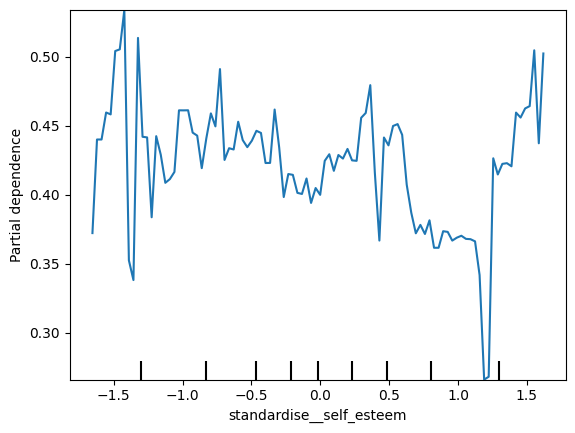

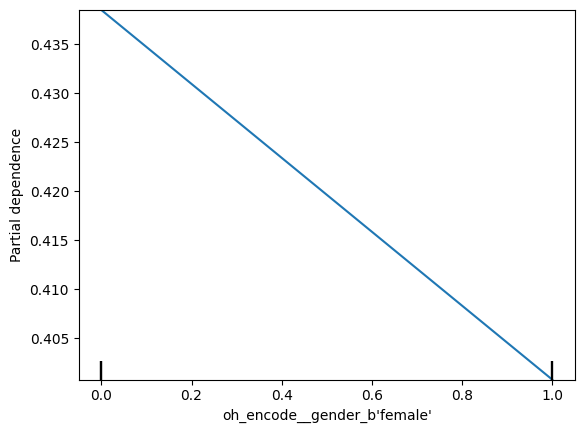

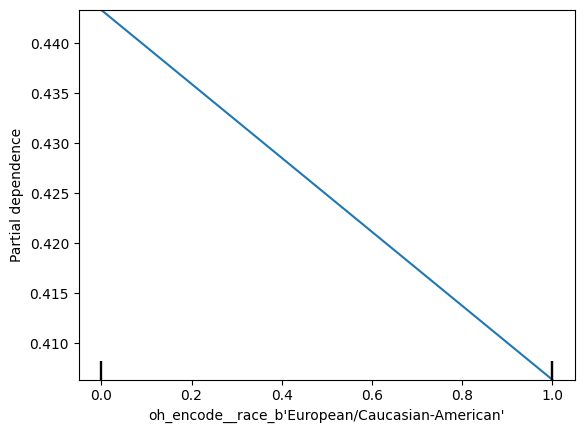

In [98]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_to_display = ["standardise__self_esteem", "oh_encode__gender_b'female'", "oh_encode__race_b'European/Caucasian-American'"]

for f in features_to_display:
    disp = PartialDependenceDisplay.from_estimator(xgb_model, X, [f])

plt.show()

The latter plots suggest that participants in the 'Female' and 'European/Caucasian-American' groups were less likely to decide 'yes' for a given partner.

The self-esteem plot is hard to decipher as-is. I will try another couple of kinds of plot to try to work out what the relationship is:

<AxesSubplot: xlabel='self_esteem', ylabel='yes_rate'>

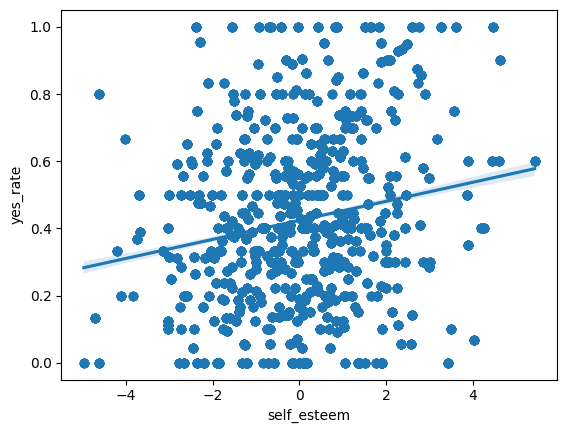

In [99]:
import seaborn as sns

df["yes_rate"] = df.groupby("identifier")["decision"].transform("mean")

df_self_esteem_test = df.loc[:, ["self_esteem", "yes_rate"]]

sns.regplot(x=df_self_esteem_test["self_esteem"], y=df_self_esteem_test["yes_rate"])

<AxesSubplot: xlabel='se_bin', ylabel='mean_yes_rate'>

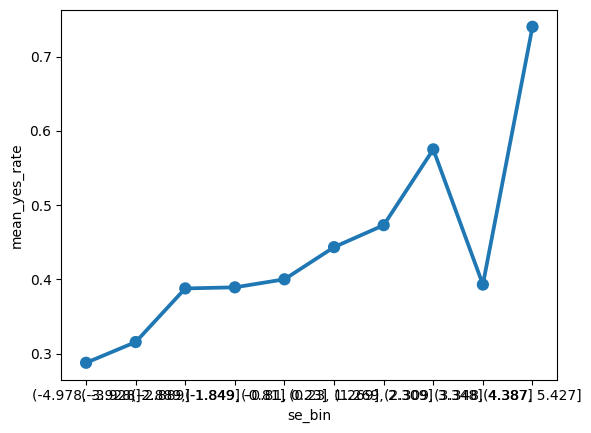

In [100]:
df_self_esteem_test["se_bin"] = pd.cut(df_self_esteem_test["self_esteem"], 10)
df_self_esteem_test["mean_yes_rate"] = df_self_esteem_test.groupby("se_bin")["yes_rate"].transform("mean")

df_self_esteem_test_2 = df_self_esteem_test.loc[:, ["se_bin", "mean_yes_rate"]].drop_duplicates()
df_self_esteem_test_2
sns.pointplot(x=df_self_esteem_test_2["se_bin"], y=df_self_esteem_test_2["mean_yes_rate"])

Interestingly, this suggests that people with higher self-esteem (or at least, higher values of this feature which I designed as a proxy for self-esteem) are slightly more likely to decide 'yes', on average. If I had had to guess beforehand, I would have expected the opposite to be true. With that said, the relationship between these variables is clearly a very noisy one.

## Which attributes matter?

Which qualities of a person really matter most? This is a slightly different question than the one we've tried answering via explainability techniques on the above match predictions, because we can just look at how the attributes (attractiveness etc.) correlate to the 'like' rating. We can also look at how the qualities that matter differ by gender.

First, we have some missing values to deal with:

In [101]:
# How many missing values do we have in the attribute ratings and like ratings?

df_mvcheck = df.loc[:, ["attractive_partner", "sincere_partner", "intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner", "like"]]
df_mvcheck.isnull().sum()

attractive_partner           201
sincere_partner              276
intelligence_partner         285
funny_partner                343
ambition_partner             694
shared_interests_partner    1027
like                         239
dtype: int64

In [102]:
# If I remove rows with nulls, how many rows will I have left?

df_mvcheck = df_mvcheck.dropna(axis=0)
df_mvcheck.shape

(6675, 7)

This still seems like a reasonable amount of data for this question, so I will proceed on that basis.

In [103]:
from sklearn.linear_model import LinearRegression

attributes = ["attractive_partner", "sincere_partner", "intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner"]
attribute_coefficients = {}

lm = LinearRegression()

for i in range(len(attributes)):
    attribute_coefficients[attributes[i]] = {}
    X_lr = df.loc[:, ["gender", attributes[i], "like"]].dropna(axis=0)
    X_lr_m = X_lr.loc[X_lr["gender"] == "b'male'"].drop("gender", axis=1)
    y_lr_m = X_lr_m.pop("like")
    model_lr_m = lm.fit(X_lr_m,y_lr_m)
    attribute_coefficients[attributes[i]]["m"] = model_lr_m.coef_[0]
    X_lr_f = X_lr.loc[X_lr["gender"] == "b'female'"].drop("gender", axis=1)
    y_lr_f = X_lr_f.pop("like")
    model_lr_f = lm.fit(X_lr_f,y_lr_f)
    attribute_coefficients[attributes[i]]["f"] = model_lr_f.coef_[0]
    #attribute_coefficients[attributes[i]]["diff"] = attribute_coefficients[attributes[i]]["m"] - attribute_coefficients[attributes[i]]["f"]
    #attribute_coefficients[attributes[i]]["count_m"] = X_lr_m.count()[0]
    #attribute_coefficients[attributes[i]]["count_f"] = X_lr_f.count()[0]

attribute_coefficients = pd.DataFrame(attribute_coefficients)
attribute_coefficients

,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner
m,0.635385,0.538828,0.585826,0.641237,0.473223,0.539010
f,0.631681,0.548811,0.632314,0.656186,0.462176,0.596088


The highest coefficient here is for the 'funny' attribute, especially for women. This implies that this may be the strongest determinant of the 'like' rating. Attractiveness is a close second, and is slightly more important for men. The least important attribute, according to this measure, is ambition.

(Note that here I am assuming that the relationship between each attribute and the 'like' score is close enough to linear for this comparison to be meaningful.)

A related question is whether the importance features (where participants split 100 'importance' points between the attributes) align with the decisions that the participants actually make.

To work this out, we should first define a set of calculated importance ratings to compare with the ones given by the participants. We could do this relatively simply on a whole-sample basis using the coefficients calculated above, by converting those coefficients into a 100-point split:

In [104]:
attribute_importances = attribute_coefficients.transpose()
attribute_importances["calculated_importance_m"] = 100* attribute_importances["m"] / attribute_importances["m"].sum()
attribute_importances["calculated_importance_f"] = 100* attribute_importances["f"] / attribute_importances["f"].sum()

attribute_importance_features = ["attractive_important", "sincere_important", "intellicence_important", "funny_important", "ambtition_important", "shared_interests_important"]

stated_importances_m = {}
stated_importances_f = {}

for i in range(len(attribute_importance_features)):
    stated_importances_m[attributes[i]] = df.loc[df["gender"] == "b'male'"].fillna(0)[attribute_importance_features[i]].mean()
    stated_importances_f[attributes[i]] = df.loc[df["gender"] == "b'female'"].fillna(0)[attribute_importance_features[i]].mean()

attribute_importances["stated_importances_m"] = pd.Series(stated_importances_m)
attribute_importances["diff_m"] = attribute_importances["calculated_importance_m"] - attribute_importances["stated_importances_m"]
attribute_importances["stated_importances_f"] = pd.Series(stated_importances_f)
attribute_importances["diff_f"] = attribute_importances["calculated_importance_f"] - attribute_importances["stated_importances_f"]


attribute_importances

,m,f,calculated_importance_m,calculated_importance_f,stated_importances_m,diff_m,stated_importances_f,diff_f
attractive_partner,0.635385,0.631681,18.613826,17.908565,26.509987,-7.896161,17.628326,0.280239
sincere_partner,0.538828,0.548811,15.785167,15.559144,16.332823,-0.547657,17.722765,-2.163621
intelligence_partner,0.585826,0.632314,17.161996,17.926515,19.311220,-2.149224,20.496168,-2.569653
funny_partner,0.641237,0.656186,18.785265,18.603305,17.637580,1.147685,16.968003,1.635302
ambition_partner,0.473223,0.462176,13.863246,13.102990,8.428923,5.434324,12.629847,0.473143
shared_interests_partner,0.539010,0.596088,15.790500,16.899481,10.778967,5.011533,12.523797,4.375684


This is quite interesting. One particular highlight is that it seems males are not as fixated on attractiveness as they say/believe they are: on average they give it 26.5 importance points, whereas the above suggests that it contributes about 18.6 importance points towards the 'like' rating.

However, this is a flawed methodology because just because someone scores a partner high on (say) ambition doesn't mean that that had any bearing on their liking them or not.

Also, this refers to how the attributes affect the 'like' rating, not necessarily the 'yes/no' decision. We should check how closely these track with each other:

<AxesSubplot: xlabel='like', ylabel='yesrate'>

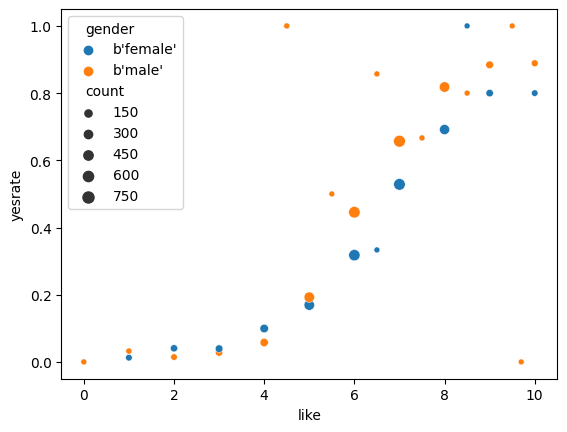

In [105]:
df_like_decision_relationship = df.loc[:, ["gender", "like", "decision"]]
df_like_decision_relationship["yesses"] = df.groupby(["gender", "like"])["decision"].transform("sum")
df_like_decision_relationship["count"] = df.groupby(["gender", "like"])["decision"].transform("count")
df_like_decision_relationship["yesrate"] = df_like_decision_relationship["yesses"] / df_like_decision_relationship["count"]
df_like_decision_relationship = df_like_decision_relationship.drop(["decision", "yesses"], axis=1).drop_duplicates().dropna()

sns.scatterplot(x=df_like_decision_relationship["like"], y=df_like_decision_relationship["yesrate"], size=df_like_decision_relationship["count"], hue=df_like_decision_relationship["gender"])

Another way to approach this question is to ask, how reliably do people give the highest like rating to the person to whom they gave the highest weighted average of attributes?

In [106]:
df_r = df.copy()
df_r["sum_of_weighted_attributes"] = df_r["attractive_partner_weighted"] + df_r["sincere_partner_weighted"] + df_r["intelligence_partner_weighted"] + df_r["funny_partner_weighted"] + df_r["ambition_partner_weighted"] + df_r["shared_interests_partner_weighted"]
df_r["identifier"] = df_r["wave"].astype(str) + df_r["gender"] + df_r["age"].astype(str) + df_r["race"].astype(str) + df_r["importance_same_race"].astype(str) + df_r["importance_same_religion"].astype(str) + df_r["attractive"].astype(str) + df_r["sincere"].astype(str) + df_r["intelligence"].astype(str) + df_r["funny"].astype(str) + df_r["ambition"].astype(str)
df_r["max_sum_attr"] = df_r.groupby("identifier")["sum_of_weighted_attributes"].transform("max")
df_r["max_like"] = df_r.groupby("identifier")["like"].transform("max")
df_r = df_r.loc[df_r["sum_of_weighted_attributes"] == df_r["max_sum_attr"]]
df_r["high_score_match"] = (df_r["like"] == df_r["max_like"]).astype(int)

df_r["high_score_match"].mean()

0.6981757877280266

So about 70% of the time, participants gave their highest like rating to the person to whom they gave the highest attribute ratings, weighted for how important they say each of those attributes is to them.

## Race and religion

There are a few interesting questions to investigate specifically around the 'race' features.

One is simply whether there are differences between the approaches of the different groups to members of other groups:

Text(0.5, 23.52222222222222, 'Picker')

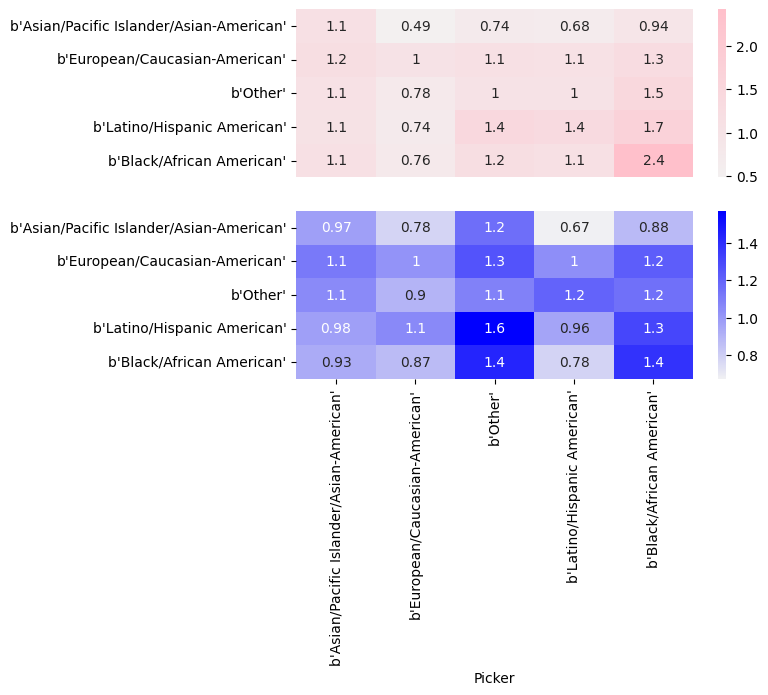

In [107]:
df_race = df.loc[:, ["race", "race_o", "samerace", "importance_same_race", "decision", "gender"]].dropna()

race_groups = list(df_race.loc[:, "race"].drop_duplicates())

df_race["race_based_yes_rate"] = df_race.groupby(["gender", "race", "race_o"])["decision"].transform("mean")
df_race["gender_mean_yes_rate"] = df_race.groupby("gender")["decision"].transform("mean")
df_race["race_based_yes_rate_relative_to_overall_gender_rate"] = df_race["race_based_yes_rate"] / df_race["gender_mean_yes_rate"]

df_race = df_race.loc[:, ["gender", "race", "race_o", "race_based_yes_rate_relative_to_overall_gender_rate"]].drop_duplicates()

race_f = {}
race_m = {}

for r in race_groups:
    race_f[r] = {}
    race_m[r] = {}
    for s in race_groups:
        race_f[r][s] = df_race.loc[(df_race["gender"] == "b'female'") & (df_race["race"] == r) & (df_race["race_o"] == s)]["race_based_yes_rate_relative_to_overall_gender_rate"].iloc[0]
        race_m[r][s] = df_race.loc[(df_race["gender"] == "b'male'") & (df_race["race"] == r) & (df_race["race_o"] == s)]["race_based_yes_rate_relative_to_overall_gender_rate"].iloc[0]

df_race_f = pd.DataFrame(race_f)
df_race_m = pd.DataFrame(race_m)

fig, ax = plt.subplots(2,1)
sns.heatmap(data=df_race_f, cmap=sns.light_palette("pink", as_cmap=True), annot=True, ax=ax[0], xticklabels=False)
sns.heatmap(data=df_race_m, cmap=sns.light_palette("blue", as_cmap=True), annot=True, ax=ax[1])
plt.xlabel('Picker')

How closely does the 'importance of being the same race as your partner' feature match how important it really seems to be to participants?

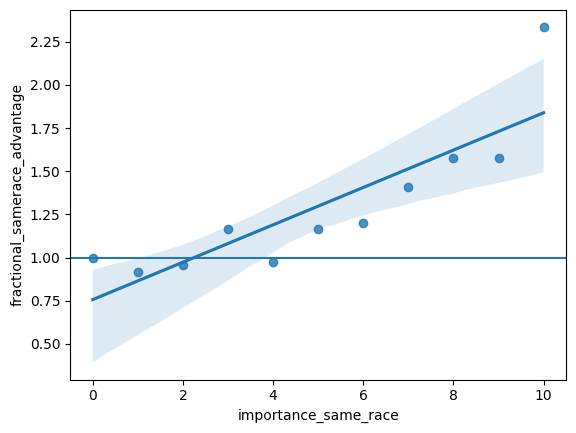

In [108]:
df_samerace = df.copy()

df_samerace["yesrate_samerace"] = df_samerace.groupby(["identifier", "samerace"])["decision"].transform("mean")

df_samerace = df_samerace.groupby(["importance_same_race", "samerace"])["yesrate_samerace"].mean().to_frame().reset_index()

samerace_prefs = {}

for i in range(11):
    samerace_prefs[i] = {"importance_same_race": i}
    for j in [-1, 1]:
        samerace_prefs[i]["yesrate_samerace_" + str(j)] = df_samerace.loc[(df_samerace["importance_same_race"] == i) & (df_samerace["samerace"] == j)]["yesrate_samerace"].iloc[0]

df_samerace_prefs = pd.DataFrame(samerace_prefs)
df_samerace_prefs = df_samerace_prefs.transpose()
df_samerace_prefs["fractional_samerace_advantage"] = df_samerace_prefs["yesrate_samerace_1"] / df_samerace_prefs["yesrate_samerace_-1"]

df_samerace_prefs
rgplt = sns.regplot(x=df_samerace_prefs["importance_same_race"], y=df_samerace_prefs["fractional_samerace_advantage"])
rgplt.axhline(1)

This tells us that participants were, on average, roughly right about how much race matters to them compared to other participants. At the lowest end of the 'importance of being the same race' spectrum, some people seem to have a preference for dating partners from different racial groups. People who rated themselves between 1 and 3 or 4 on this feature appear to be genuinely neutral, choosing partners of different races at about the same rate as they choose partners of the same race. Beyond that, participants tended to have a preference for partners of the same race, and this had a greater bearing on decisions for those who gave a higher score for the importance of being the same race.

## Self-perception

How do people's self-scores on qualities differ from those that others give them?

In [109]:
df_sp = df.loc[:, ["identifier", "gender", "attractive", "attractive_o", "sincere", "sinsere_o", "intelligence", "intelligence_o", "funny", "funny_o", "ambition", "ambitous_o"]].dropna(axis=0).copy()

#There are a couple of zero ratings in the 'attractive_o' feature which would cause problems, so I will replace those 0s with 1s
df_sp.loc[df_sp["attractive_o"] == 0, "attractive_o"] = 1

df_sp["attractiveness_ratio"] = df_sp["attractive"] / df_sp["attractive_o"]
df_sp["sincere_ratio"] = df_sp["sincere"] / df_sp["sinsere_o"]
df_sp["intelligence_ratio"] = df_sp["intelligence"] / df_sp["intelligence_o"]
df_sp["funny_ratio"] = df_sp["funny"] / df_sp["funny_o"]
df_sp["ambition_ratio"] = df_sp["ambition"] / df_sp["ambitous_o"]

ratio_features = ["attractiveness_ratio", "sincere_ratio", "intelligence_ratio", "funny_ratio", "ambition_ratio"]

for ft in ratio_features:
    df_sp[ft] = df_sp.groupby("identifier")[ft].transform("mean")

df_sp = df_sp.loc[:, ["gender", "attractiveness_ratio", "sincere_ratio", "intelligence_ratio", "funny_ratio", "ambition_ratio"]]
    
df_sp = df_sp.groupby("gender")[ratio_features].mean()
df_sp["sum"] = df_sp.sum(axis=1)
df_sp

,attractiveness_ratio,sincere_ratio,intelligence_ratio,funny_ratio,ambition_ratio,sum
gender,,,,,,
b'female',1.271559,1.243203,1.146315,1.450021,1.269751,6.380849
b'male',1.413608,1.308670,1.087945,1.626129,1.219305,6.655657


We don't know what the ground truth is about each person's attributes, so these scores don't necessarily tell us simply how much people overestimate their attributes. Rather, they tell us how much better participants believe their scores should be than those they tend to receive.

So both male and female participants tended to overestimate their scores compares to the scores others gave them. For both genders, the biggest disparity was for 'funny' and 'attractive', and the smallest disparity was for 'intelligent'. Overall, males over-scored themselves slightly more than females did (or equivalently, females under-scored men more than vice-versa).

# Caveats

* We need to bear in mind that this is not a representative sample of the population - for a start, it is mostly twenty-somethings, from a specific place and time, with a bias towards academic types, who are the sort of people to go speed-dating (so more likely to be outgoing/extroverted). Scores could be very different for different populations.

* If using more modern data, we would probably expect to have more gender options and LGBT pairings, which might change results and would certainly make some of the processing more complicated if we were to perform similar analysis on newer data.